# Unit 3 - Supervised Learning Capstone
## Estimating the Possibility of Credit Card Default

#### John A. Fonte

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Explanation of the Dataset 

This is a collection of 2005 customer risk data acquired by Chung Hua University and Tamkang University of Taiwan. The goal in acquiring this data was to establish risk probability of default from general demographic features as well as timeliness of payments of the last six (6) months of payments.

__Original citation:__ Yeh, I. C., & Lien, C. H. (2009). _The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients._ Expert Systems with Applications, 36(2), 2473-2480.

__Link to Data:__ [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

__Link to this Notebook:__ [My Github](https://github.com/jafonte01/CAPSTONE-Supervised_Learning)

In [2]:
# importing data
df = pd.read_csv('C:/Users/jafon/Documents/PythonMaterials/Data/Capstone-Unit3/credit card defaulters/creditcarddata - Data.csv')
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

              ...              BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
0             ...                      0          0          0         0   
1             ...                   3272       3455       3261         0   
2             ...                  14331      14948      15549      1518   
3             ...                  28314      28959      29547      2000   
4             ...                  20940      19146      19131      2000   

   PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0       689         0         0         0         0   
1      1000      1000      1000         0      2000   
2      1500      1000      1000      1000      5000   
3      2019      1200      1100      1069      1000   
4     36681     10000      9000       689       679   

   default payment next month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0  

[5 rows x 25 columns]

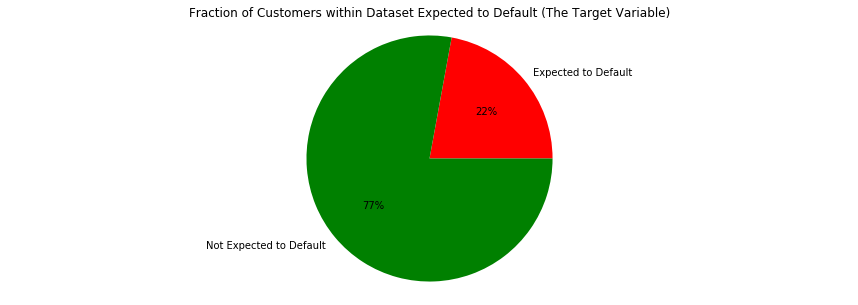

Total Number of Customers Reviewed is 30,000.


In [3]:
# Overview of the target variable: expected default (1) or not expected to default (0)


# default vs. non-default values taken from df['default payment next month']
pievalues = [6636/(6636 + 23364), 23364/(6636 + 23364)] 
pielabels = ['Expected to Default', 'Not Expected to Default']

plt.figure(figsize=(15,5)) 
plt.pie(pievalues, autopct='%d%%', labels=pielabels, colors=['red', 'green'])
plt.axis('equal')
plt.title('Fraction of Customers within Dataset Expected to Default (The Target Variable)')
plt.show()
print("Total Number of Customers Reviewed is 30,000.")

__NOTE:__ Class imbalance will be addressed later in this project.

In [4]:
# Quick adjustments to dataset - changing 1's and 2's to 0's and 1's for aesthetic convention 
# (i.e., DO ********NOT******** run more than once!)
df['SEX'] = df.SEX - 1
df['EDUCATION'] = df.EDUCATION - 1
df['MARRIAGE'] = df.MARRIAGE - 1

In [5]:
df.columns # viewing what I am working with

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

---
## Explanation of Columns
   - 1. __ID__ - The ID number associated with the particular credit card customer. <br><br>
   - 2. __Limit_Bal__ - The credit card limit (in USD) of the credit card associated with the particular customer.<br><br>
   - 3. __Sex__ - Sex of customer {O:Male, 1:Female}.<br><br>
   - 4. __Education__ - Highest education obtained by customer {0:graduate school, 1:undergraduate college, 2:high school, 3:other}.<br><br>
   - 5. __Marriage__ - Marital status of customer {0:married, 1:single, 2:"other"}.<br><br>
   - 6. __Age__ - Age (in number of years) of customer.<br><br>
   - 7. to 12. __Pay_X__ - History of past payments. Timing of payments for April to September 2005, with 'PAY_0' being the payment for the September 2005 bill, 'PAY_1' for August 2005 bill, and backwards from there. <br><br>
           - A '2' denotes that the payment was made 2 months after the due date, '3' denotes that the payment was made 3 months after the due date, ... '9' means 9 months or more the payment was made. A '0' or negative number denotes that the payment was made on \[or ahead of\] time.<br><br>
   - 13. to 18. __Monthly Bill Statement__ - The balance due for a given month from April to September 2005, with 'BILL_AMT1' being the bill statement for September 2005, 'BILL_AMT2' for August 2005, and backwards from there.<br><br>
   - 19. to 24. __Amount Paid per Month__ - The amount actually paid (in USD) by the customer for a given month from April to September 2005, with 'PAY_AMT1' being the amount paid towards the September 2005 bill, 'PAY_AMT2' towards the August 2005 bill, and backwards from there.   

# Data Cleaning

Before performing _any_ analysis on the data, we first need to curate the data; obviously, failing to do so first would result in visualizing incorrect, incomplete, and overall potentially misleading data.\*

Cleaning analysis entails:
- Checking if data types (int, float, str, etc.) are correct for each column
- Deleting or imputing _NaN_ values.
- Identifying "wonky" data points, and deciding what to do with them (delete them, transform them, etc.)

---
\* This will have to be done again if we include new or modified features.

In [6]:
# quick data cleaning check
df[df.isna().any(axis=1)]

# well...that'll do it!
# we will cross other cleaning bridges, 
# such as wrong data types and wonky data points as we go.

Empty DataFrame
Columns: [ID, LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6, default payment next month]
Index: []

[0 rows x 25 columns]

# Data Visualization

Before delving into the minutia of the strength of individual features, it is important to at least _look_ at your data. As a brief overview, we will be analyzing default/no default in light of demographic data, particularly:
- Sex (M/F)
- Education (graduate school/undergraducate school/high school/"other")
- Marriage (married/single/"other")
- Age

It is a conscious decision not to visualize _every_ variable as that dilutes the analysis and clutters up the project as a whole. Remember, the goal of visualization is to understand the dataset better. Additional graphs provide diminishing returns of dataset understanding, and so a data scientist must be judicious in terms of what data features to further investigate.

Finally, included in these visualizations is a histogram analysis of the demographic data. Keeping tabs on normal data as opposed to non-normal data is important in machine learning, as many models assume a normal distribution to provide accurate results and predictions.

---
### Sex

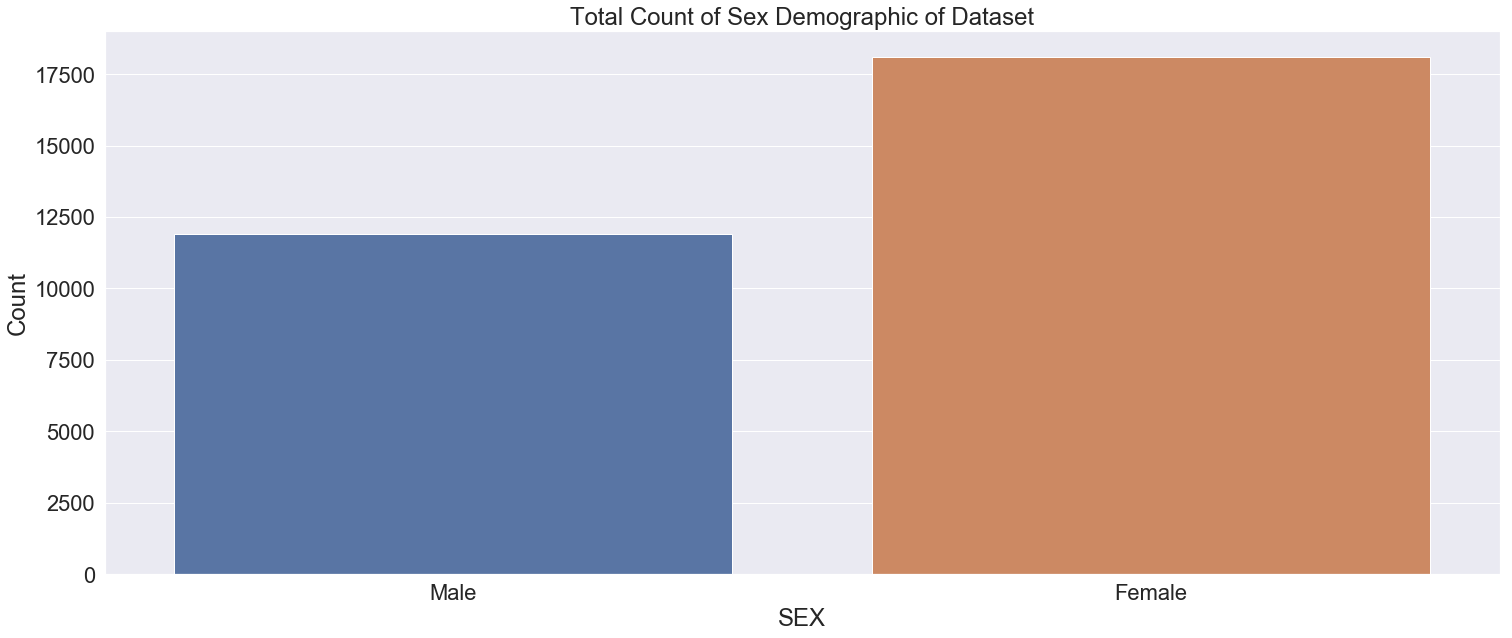

In [7]:
plt.figure(figsize=(25,10))

sns.set_style('darkgrid')
sns.set(font_scale = 2)

sns.countplot(x='SEX', data=df)
plt.title('Total Count of Sex Demographic of Dataset')
plt.ylabel('Count')
plt.xticks([0,1], ['Male', 'Female'])
plt.show()

Slightly imbalanced. Making a mental note...

---

The following visualizations will contain "sex" as a hue to other demographic features. Before moving onto those other demographic features, we will take an initial look into credit card balance differences in sex.

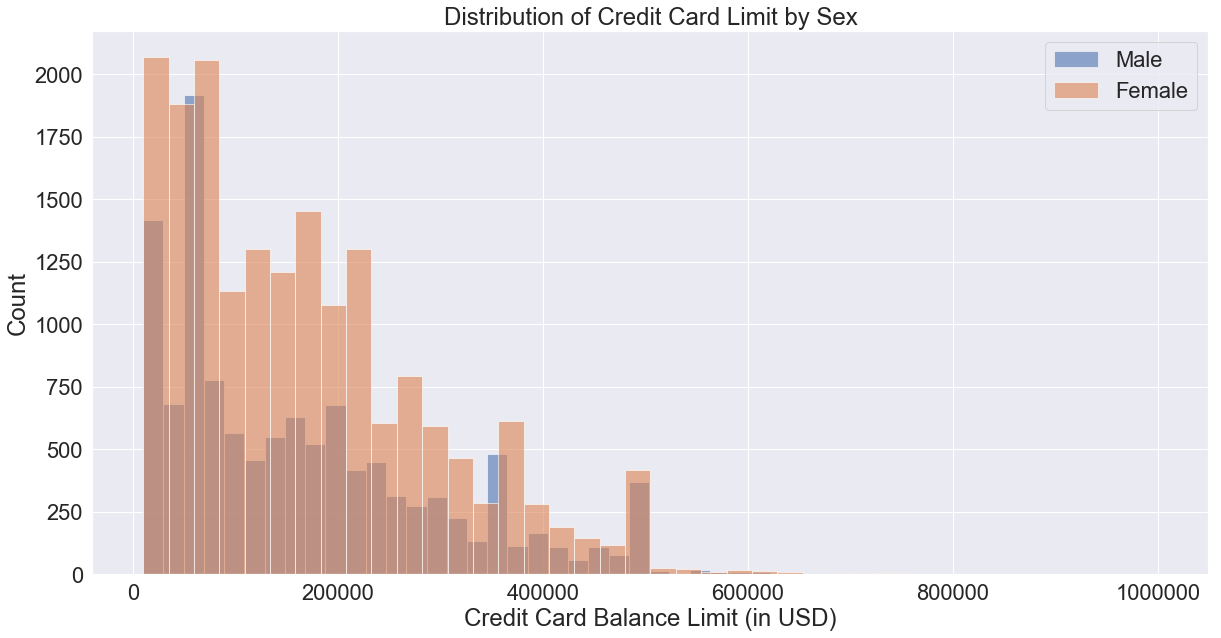

In [8]:
# doing initial histogram for check on normality of distribution

dfmale = df[df.SEX == 0].copy()
dffemale = df[df.SEX == 1].copy()

plt.figure(figsize=(20,10))

plt.hist(x=dfmale['LIMIT_BAL'], bins=40, alpha=0.6, label='Male')
plt.hist(x=dffemale['LIMIT_BAL'], bins=40, alpha=0.6, label='Female')
plt.legend()
plt.title('Distribution of Credit Card Limit by Sex')
plt.ylabel('Count')
plt.xlabel('Credit Card Balance Limit (in USD)')
#plt.hist(x=dffemale['Credit Balance Limit (USD)'], bins=40, alpha=0.6)
plt.show()

This non-normal distribution is expected; having a normal distribution of a credit card balance limit would be surprising. Accordingly, it is cautioned using this feature...

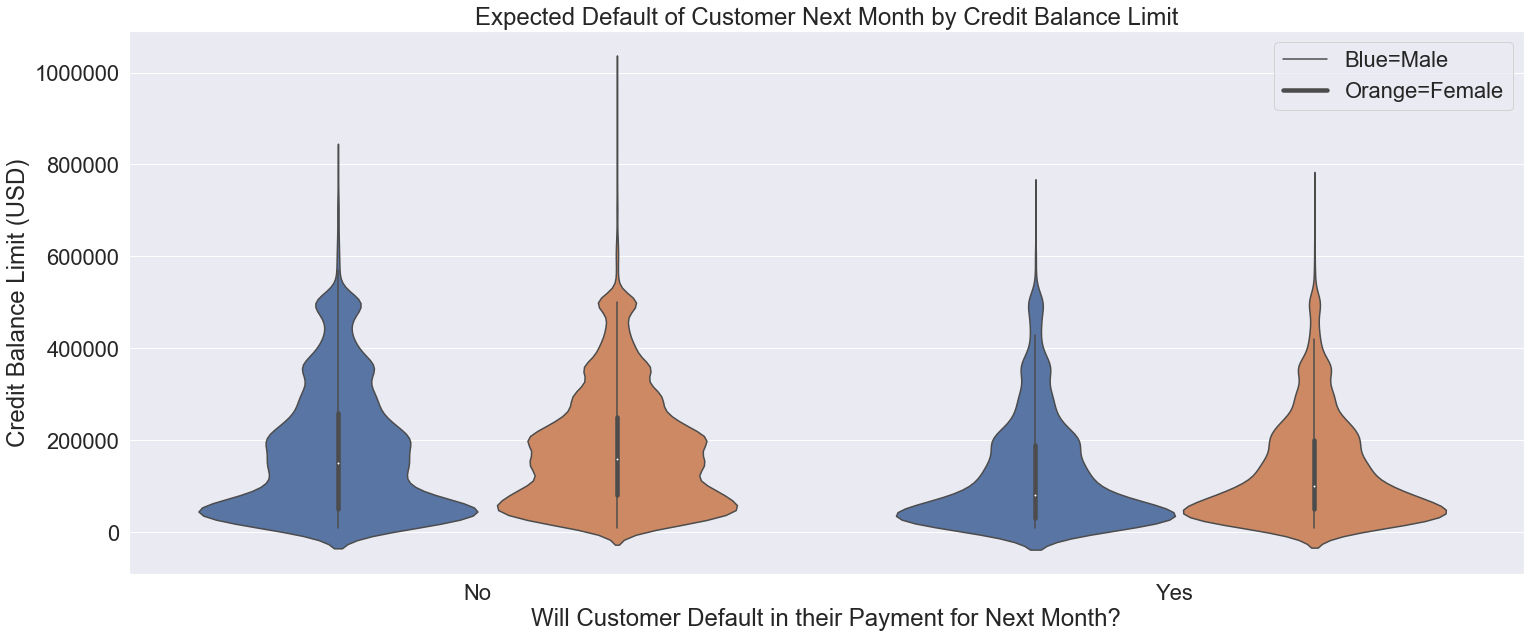

In [9]:
#--------------------------------------------------------
# Rest of visualizations will check if a demographic factors into default/no default

# Look at credit card balance via a violinplot

plt.figure(figsize=(25,10))

sns.set_style('darkgrid')
sns.set(font_scale = 2)

sns.violinplot(x='default payment next month', y='LIMIT_BAL', hue='SEX', data=df)
plt.legend(labels=['Blue=Male', 'Orange=Female'], loc='upper right')
plt.title('Expected Default of Customer Next Month by Credit Balance Limit')
plt.ylabel('Credit Balance Limit (USD)')
plt.xlabel('Will Customer Default in their Payment for Next Month?')
plt.xticks(ticks=range(0,2), labels=['No', 'Yes'])

plt.show()

In [10]:
#--------------------------------------------------------------
# prepping features "EDUCATION" and "MARRIAGE" for analysis

#dropping all values where Education is < 0 or Marriage < 0, as those are "undefined values"
print(df.EDUCATION.value_counts())
print(df.MARRIAGE.value_counts())

 1    14030
 0    10585
 2     4917
 4      280
 3      123
 5       51
-1       14
Name: EDUCATION, dtype: int64
 1    15964
 0    13659
 2      323
-1       54
Name: MARRIAGE, dtype: int64


In [11]:
# doing the fix here
df = df[(df.EDUCATION < 4) & (df.EDUCATION >= 0) & (df.MARRIAGE >= 0)]
print(df.EDUCATION.value_counts())
print(df.MARRIAGE.value_counts())

1    14024
0    10581
2     4873
3      123
Name: EDUCATION, dtype: int64
1    15806
0    13477
2      318
Name: MARRIAGE, dtype: int64


---
### Education

In [12]:
# Education distribution visualization

plt.figure(figsize=(15,5))

sns.set_style('darkgrid')
sns.set(font_scale = 1.5)

sns.countplot(x='EDUCATION', data=df)
plt.title('Total Count of Education Demographic of Dataset')
plt.ylabel('Count')
plt.xticks(range(0,4), ['Graduate School', 'Undergrad College', 'High School', 'Other'])
plt.show()

In [13]:
# credit balance visualization

sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

g = sns.catplot(x='default payment next month', y='LIMIT_BAL', hue='SEX', 
            col='EDUCATION', data=df, kind='boxen', 
            col_wrap=2, aspect=1.5, legend=False, sharex=False, sharey=True, size=4)


g.fig.suptitle('Expected Default of Customer Next Month by Credit Card Limit')
g.fig.subplots_adjust(top=.9)
g.fig.legend(labels=['Blue=Male', 'Orange=Female'], loc='upper left')

g.set_ylabels('Credit Balance Limit (USD)')
g.set_xlabels('Will Customer Default in their Payment for Next Month?')
plt.xticks(ticks=range(0,2), labels=['No', 'Yes'])
plt.show()

print('Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:\'Other\'}')

C:\Anaconda\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:'Other'}


---
---
### Marriage

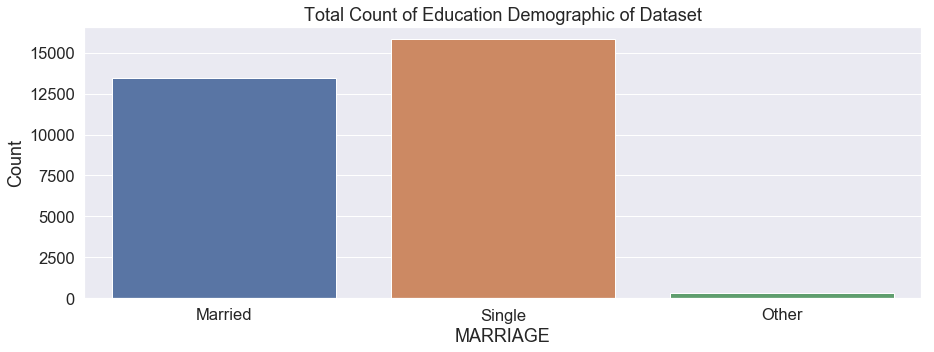

In [14]:
# Marriage distribution visualization

plt.figure(figsize=(15,5))

sns.set_style('darkgrid')
sns.set(font_scale = 1.5)

sns.countplot(x='MARRIAGE', data=df)
plt.title('Total Count of Education Demographic of Dataset')
plt.ylabel('Count')
plt.xticks(range(0,3), ['Married', 'Single', 'Other'])
plt.show()

In [15]:
# continued data visualization
# doing Category plot to see if timing of payment plays factor

sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

g = sns.catplot(x='default payment next month', y='LIMIT_BAL', hue='SEX', 
            col='MARRIAGE', data=df, kind='boxen', 
            col_wrap=2, aspect=1.5, legend=False, sharex=False, sharey=True, size=4)


g.fig.suptitle('Expected Default of Customer Next Month by Timing Of Payments')
g.fig.subplots_adjust(top=.9)
g.fig.legend(labels=['Blue=Male', 'Orange=Female'], loc='upper left')

g.set_ylabels('Average Timing of Payment')
g.set_xlabels('Will Customer Default in their Payment for Next Month?')
plt.xticks(ticks=range(0,2), labels=['No', 'Yes'])
plt.show()

print('A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.')
print('Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:\'Other\'}')

C:\Anaconda\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.
Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:'Other'}


---
---
### Age

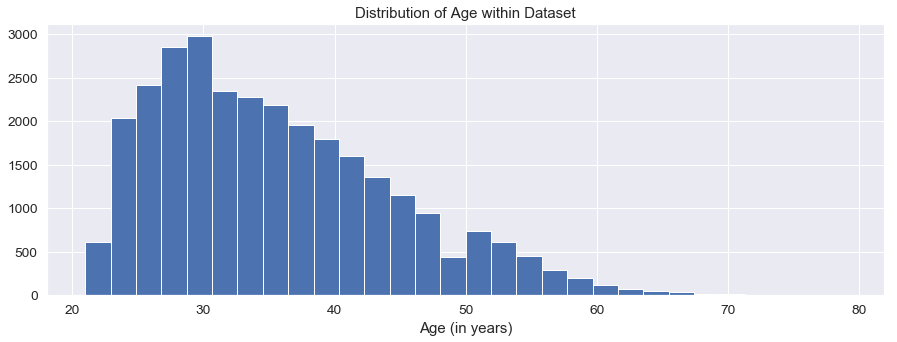

In [16]:
# Finally, AGE demographic
plt.figure(figsize=(15,5))

plt.hist(x=df.AGE, bins=30)
plt.title('Distribution of Age within Dataset')
plt.xlabel('Age (in years)')
plt.show()

In [17]:
# looking at age for default/no default by age and credit limit
'''
Unlike above, age is ***continuous*** variable, 
so a scatterplot more appropriate than the above violin plots and
other distribution box plots that are apropos for categorical variables.
'''

agedefault = df[df['default payment next month'] == 1].copy()
agenodefault = df[df['default payment next month'] == 0].copy()

plt.figure(figsize=(15,10))

plt.scatter(x=agenodefault.AGE, y=agenodefault.LIMIT_BAL, alpha=0.7, color='blue')
plt.scatter(x=agedefault.AGE, y=agedefault.LIMIT_BAL, alpha=0.7, color='red')
plt.title('Credit Card Limit by Age')
plt.xlabel('Age (in years)')
plt.ylabel('Credit Card Balance Limit (in USD)')
plt.show()

### Brief Observation on "Credit Balance Limit"

Those individuals with lower credit balance limits (identified as `df.LIMIT_BAL`), regardless of sex, education, marriage, or age, defaulted in their credit card payment in the following month.  This observation suggests that a lower balance limit is a __result of__ other financial factors that ultimately contribute to the default, but the limit itself is NOT the cause. 

This result is indicative of us putting the analytical cart before the horse. In other words, we should first figure out which features explain the target variable of default/no default the best. Once we figure out a starting point, then we can look into those features more closely.

---
# Feature Selection and Feature Engineering

The above visualization analysis emphasizes an important point in machine learning: chucking the entire dataset into a model does not help the model. In other words, more data does __not__ equate to a more accurate result. Not only will having the model analyze more information slow down the model, some features may actually _detract_ from a better result.

To avoid this, we need to __select__ features. Moreover, it is common to create, or "engineer", features to enhance explanatory power. 

We will deal with feature selection first.

## Feature Selection

How does one find out which features are most important in correlating with and explaining the target variable? Furthermore, is there a way to identify the _extent_ which a given feature correlates and explains?

There are a number of feature selection techniques, each with their own emphases, pros, and cons. Below is a list of feature selection techniques used here:

1. LASSO regression combined with a "leave-one-out" method
2. Permutation Importance, specifically tree-based modeling
3. Correlative heatmap
4. SHAP value analysis
5. Partial Dependence Plot
6. Dependence Contribution Plot

Much like the order of analysis for feature visualization, if it is determined that there is a weak correlation between the features and the target variable, we will have to switch gears and perform feature engineering, _and then_ we will confirm that the added features will help by resuming out feature selection process.

---

### Feature Selection: LASSO Regression

LASSO regression is logistic regression with a L1 regularization penalty. __Logistic Regression__ is a regression analysis on the _probability_ that a datapoint will be characterized as falling in one category (1 or will default) over another (0 or will not default). In other words, while it is accurately defined as a regression analysis, it is used for categorical problems, such as this one here.

__L1 Regularization__ acts to penalize less important features, thus emphasizing the more important features (i.e., the features that are most correlated with the target variable). The LASSO penalty is effective with datasets that have a very large feature space.

As a feature selection, we will use a common "hold-one-out" method.* For this method, we will purposely take out a single feature and run the regression model. If the model's accuracy score drops significantly, we can conclude that the feature taken out is important to the model's analysis. The LASSO penalty will create a starker accuracy difference.

---
\*This is essentially how LASSO works: if the model works well enough without a feature, it will penalize that feature down to zero. However, this is all done on the backend; LASSO does not indicate _which_ features are being excluded. Therefore, a more explicit holdout method is employed.


In [18]:
# Warnings are annoying!

import warnings
warnings.filterwarnings(action='ignore')

In [19]:
# Setting X and Y for the model

# Using all numeric variables (including dummy'ed features)

X = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

Y = df['default payment next month']

In [20]:
# Final check - checking coefficient importances with LASSO regression (a feature selection method)

from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logistregr = LogisticRegression(penalty='l1', C=0.65) # C is the inverse of the strength of the penalty parameter 'lambda'

'''
Doing a hold-one-out method analysis (len(X.columns) - 1) times 
will take a while, hence cv only being 3.

Also, cross_val_score does the fitting for you, so no separate .fit line.
'''

# performing manual hold-one-out method
for dropped_column in X.columns:
    Xholdout = X.drop(columns=[dropped_column]) # holding out a single column
    print('\nR-squared WITHOUT column: ', dropped_column)
    print(cross_val_score(logistregr, Xholdout, Y, cv=3)) # performing cross-val analysis for each holdout


R-squared WITHOUT column:  LIMIT_BAL
[0.80512769 0.81250633 0.8072167 ]

R-squared WITHOUT column:  SEX
[0.80512769 0.81382386 0.80893979]

R-squared WITHOUT column:  EDUCATION
[0.80512769 0.81341847 0.80701399]

R-squared WITHOUT column:  MARRIAGE
[0.80431698 0.81250633 0.80883844]

R-squared WITHOUT column:  AGE
[0.80563437 0.81463464 0.80701399]

R-squared WITHOUT column:  PAY_0
[0.79296717 0.79243944 0.79424285]

R-squared WITHOUT column:  PAY_2
[0.80715444 0.81260768 0.8065072 ]

R-squared WITHOUT column:  PAY_3
[0.80472233 0.81473599 0.80914251]

R-squared WITHOUT column:  PAY_4
[0.80451966 0.81483734 0.80762214]

R-squared WITHOUT column:  PAY_5
[0.80492501 0.8141279  0.80802757]

R-squared WITHOUT column:  PAY_6
[0.80502635 0.81382386 0.80812893]

R-squared WITHOUT column:  BILL_AMT1
[0.80563437 0.81311442 0.80782485]

R-squared WITHOUT column:  BILL_AMT2
[0.80533036 0.8141279  0.80812893]

R-squared WITHOUT column:  BILL_AMT3
[0.80553304 0.8143306  0.80802757]

R-squared WITH

With the exception of the feature `PAY_0`, it does not appear any of the features are particularly important. Let's see if another feature selection method will identify standout features.

---
### Permutation Importance Modeling - Decision Tree Feature Importances

__Permutation Importance__ is a method of modeling that determine _which_ features are important. Permutation Importance is performed through models that use certain features to gain more information. Which kinds of models do this? Well...

#### Decision Tree Models\* 

are non-parametric\** supervised learning models that create conditionals that split the data into diverging nodes at a lower layer of the tree. The splitting continues until it arrives at an answer (default or no default). Every split decreases _entropy_ (measurement of differences within the data) until it achieves homogeneity.

The beauty of decision trees is that the features it uses as the conditional statements that split the data is all determined on the backend. Sure, this "beauty" is more accurately characterized as a black box, but for purposes of feature importance, the tree directly __tells us__ which features it found to be important. No heavy lifting on the data scientist's end! We will find this feature importance using the `.feature_importance()` method of the tree.

---
\*The model that we are using, __Random Forest Classifier__, is an ensemble model that is a collection of decision trees, which are averaged (but not boosted). More modeling means higher accuracy, but higher accuracy could also suggest overfitting.

\*\*__Non-parametric__ means that the input data is not required to be normally distributed for the model to analyze accurately.

In [21]:
# importing relevant sklearn model 
from sklearn import ensemble

# model instantiation
rfc = ensemble.RandomForestClassifier(n_estimators=250, random_state=444)
'''
Some important default parameters used in this model:
bootstrap=True  :  also known as "bagging", trees are run in parallel, 
                   and their values are averaged for an overall result
                   
max_depth=None  :  No maximum amount of layers in the decision trees. 
                   Yields higher accuracy, but (1) more prone to overfitting, and 
                   (2) more computationally demanding
                   
min_impurity_decrease=0 : indicative that no minimum threshold for learning
min_impurity_split=0

criterion='gini': "Gini" coefficient, which is a measurement of variance/dispersion within a dataset
                  coefficient value of "0" means most accurate. It is an error measurement.
'''

# sample check for accuracy
# takes about 10 seconds due to higher # trees (default n_estimators==10)  
cross_val_score(rfc, X, Y, cv=5)

array([0.80391826, 0.80861486, 0.81790541, 0.82652027, 0.81790541])

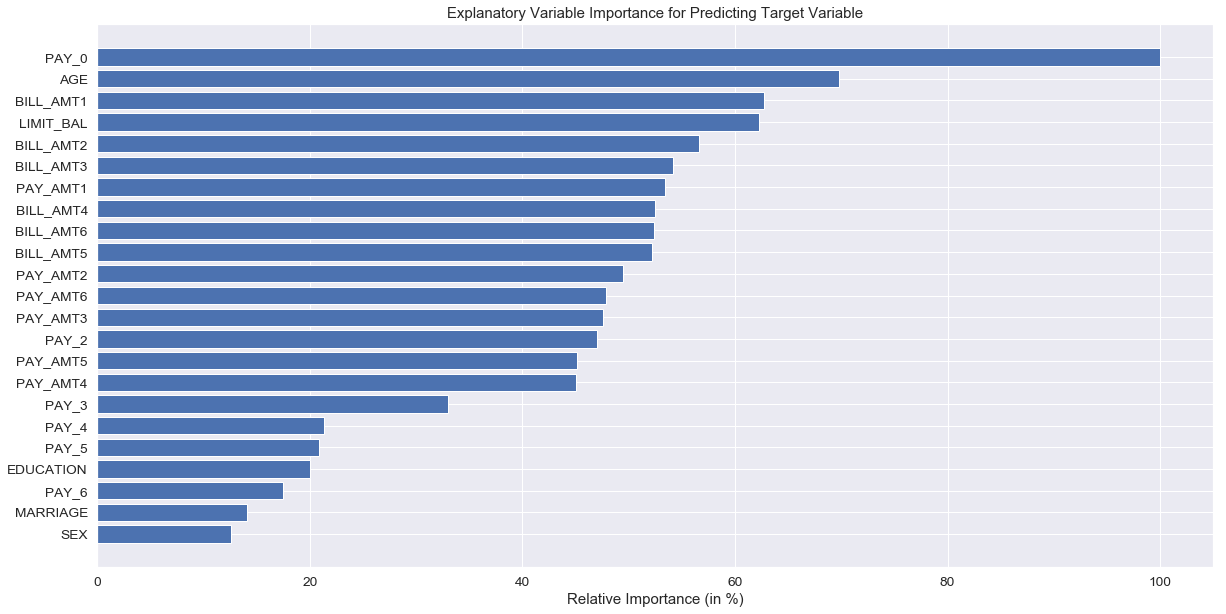

In [22]:
# checking feature importance derived from this model

# never officially fit the model 
#(done automatically via cross_val_score but need to explicitly do here)
rfc.fit(X,Y)
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(20,10))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance (in %)')
plt.title('Explanatory Variable Importance for Predicting Target Variable')
plt.show()

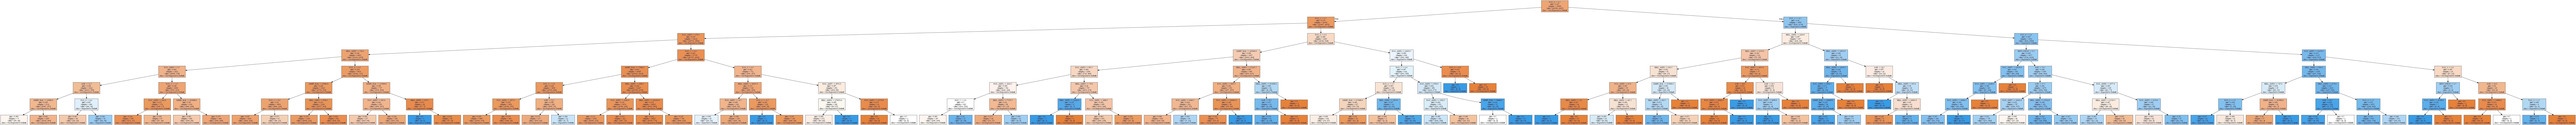

In [23]:
# graphing **sample** decision tree for a visual reference for determining relative importance

from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_depth=7, # wanted to do 10 but simply can't fit it here
)
decision_tree.fit(X, Y)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Not Expected to Default', 'Expected to Default'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
treeimage = Image(graph.create_png())

treeimage

In [24]:
print("The accuracy of this decision tree's results are {}%.".format(decision_tree.score(X, Y))) # somewhat accurate using all the data

The accuracy of this decision tree's results are 0.8283503935677848%.


In [25]:
# saving the image in case something happens - don't need to run more than once!
# graph.write_png('D:/Github/Data-Science-Bootcamp/CAPSTONE - Supervised Learning/CAPSTONE-Supervised_Learning/tree_image.png')

#### Two Notes on this Sample Decision Tree

1. The initial output displays the entire tree, i.e., in very small font. In Jupyter Notebook, you can double click on the tree to enlarge the image.

2. Analysis-wise, this decision tree blurb supports the random forest feature importance measurement - critical determinations at the upper nodes were made via PAY_0, BILL_AMT1, and LIMIT_BAL, as some examples. Just noting for reasons of feature importance analysis.

### Feature Importance Analysis

Judging from our feature importances derived from our Random Forest, it appears that the _individual_ features do not yield explanatory power. As seen before, AGE very mildly explains the variance. 

The one other feature that significant relative\* importance is `PAY_0`. This feature shows the timing of a credit card payment for the month before the month that is being measured as default or not default. Of course, if the person fails to pay the credit card on the month before (or pays it late), this would obviously be a highly important feature.

However, the circumstances of PAY_0 are highly specific to the dataset - this dataset measures a specific six-month period. It would not be a predictive indicator of whether other debtors will default.

---
\*It is important to emphasize that the feature importance graph compares _relative_ importances. It does not suggest that PAY_0 100% directly explains the target variable. It means that it was the most important, and the importances of all other features are compared to to the importance of PAY_0 (hence the "relative-ness" of the graph). In essence, that graph does __not__ indicate just how important _any_ of the features are.

---
## Feature Engineering

Without any on-point features, we will have to create our own. We can transform, aggregate, or get creative.

There will be a number of features created here. After these features are created, we will do another round of data visualization, and then we will resume feature importance analysis via the other feature importance methods mentioned above. 

In [26]:
# Creating new aggregated columns for individual-month features
df['payment timing avg'] = (df.PAY_0 + df.PAY_2 + df.PAY_3 + df.PAY_4 + df.PAY_5 + df.PAY_6) / 6

In [27]:
# I want to see if this makes any difference if I average the columns
df['bill amount avg.'] = (df.BILL_AMT1 + df.BILL_AMT2 + df.BILL_AMT3 + df.BILL_AMT4 + df.BILL_AMT5 + df.BILL_AMT6) / 6
df['pay amount avg.'] = (df.PAY_AMT1 + df.PAY_AMT2 + df.PAY_AMT3 + df.PAY_AMT4 + df.PAY_AMT5 + df.PAY_AMT6) / 6
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    1          1         0   24      2      2     -1     -1   
1   2     120000    1          1         1   26     -1      2      0      0   
2   3      90000    1          1         1   34      0      0      0      0   
3   4      50000    1          1         0   37      0      0      0      0   
4   5      50000    0          1         0   57     -1      0     -1      0   

        ...         PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0       ...                0       689         0         0         0   
1       ...                0      1000      1000      1000         0   
2       ...             1518      1500      1000      1000      1000   
3       ...             2000      2019      1200      1100      1069   
4       ...             2000     36681     10000      9000       689   

   PAY_AMT6  default payment next month  payment timing avg  bill amount avg.  \
0         0                           1           -0.333333       1284.000000   
1      2000                           1            0.500000       2846.166667   
2      5000                           0            0.000000      16942.166667   
3      1000                           0            0.000000      38555.666667   
4       679                           0           -0.333333      18223.166667   

   pay amount avg.  
0       114.833333  
1       833.333333  
2      1836.333333  
3      1398.000000  
4      9841.500000  

[5 rows x 28 columns]

In [28]:
# Creating a ratio feature from the above aggregation, 
# so that it is normalized across data points

df['bill paid to bill total ratio'] = df['pay amount avg.'] / df['bill amount avg.']

In [29]:
# New feature - is a person consistently making payments, 
# even if a single dollar for a given month?

consistent_payment = []

for s, t, u, v, w, y, a, b, c, d, e, f in zip(df['BILL_AMT1'], df['BILL_AMT2'], df['BILL_AMT3'], 
                                              df['BILL_AMT4'], df['BILL_AMT5'], df['BILL_AMT6'],
                                              df['PAY_AMT1'], df['PAY_AMT2'], df['PAY_AMT3'], 
                                              df['PAY_AMT4'], df['PAY_AMT5'], df['PAY_AMT6']):
    billamt = s + t + u + v + w + y
    payamt = a + b + c + d + e + f
    if billamt != 0 and payamt != 0:
        consistent_payment.append(0)
    
    elif billamt == 0 and payamt == 0: # making sure there is no flag for instances where the balance is zero
        consistent_payment.append(0)
        
    else:
        consistent_payment.append(1) # i.e., not a consistent payment
         

df['Consistent Payment?'] = pd.Series(consistent_payment)

In [30]:
# New feature
# Is a person making payments "more" on time as the months go on?

faster_payor = []
for i, j, k, l, m, n in zip(df['PAY_0'], df['PAY_2'], df['PAY_3'], df['PAY_4'], df['PAY_5'], df['PAY_6']):
    
    all_zero = ((i <= 0) & (j <= 0) & (k <= 0) & (l <= 0) & (m <= 0) & (n <= 0)) # '<' accounting for payments ahead of schedule
    all_same = ((i == j) & (j == k) & (k == l) & (l == m) & (m == n) & ~all_zero)
    
    if all_zero:
        faster_payor.append(1) # showing person consistently pays on time - a good thing (1)
    elif all_same:
        faster_payor.append(0) # has to have *some* improvement (0)
    elif ((i >= j) & (j >= k) & (k >= l) & (l >= m) & (m >= n) & all_same is False): # faster payment a good thing (1)
        faster_payor.append(1)
    else:
        faster_payor.append(0) # catch-all if I missed anything

df['Faster Payor'] = pd.Series(faster_payor)
        
df.tail(5)        

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
29995  29996     220000    0          2         0   39      0      0      0   
29996  29997     150000    0          2         1   43     -1     -1     -1   
29997  29998      30000    0          1         1   37      4      3      2   
29998  29999      80000    0          2         0   41      1     -1      0   
29999  30000      50000    0          1         0   46      0      0      0   

       PAY_4      ...       PAY_AMT4  PAY_AMT5  PAY_AMT6  \
29995      0      ...           3047      5000      1000   
29996     -1      ...            129         0         0   
29997     -1      ...           4200      2000      3100   
29998      0      ...           1926     52964      1804   
29999      0      ...           1000      1000      1000   

       default payment next month  payment timing avg  bill amount avg.  \
29995                           0            0.000000     120891.500000   
29996                           0           -0.666667       3530.333333   
29997                           1            1.333333      11749.333333   
29998                           1           -0.166667      44435.166667   
29999                           1            0.000000      38479.000000   

       pay amount avg.  bill paid to bill total ratio  Consistent Payment?  \
29995      7091.666667                       0.058661                  NaN   
29996      2415.000000                       0.684071                  NaN   
29997      5216.666667                       0.443997                  NaN   
29998     24530.166667                       0.552044                  NaN   
29999      1384.666667                       0.035985                  NaN   

       Faster Payor  
29995           NaN  
29996           NaN  
29997           NaN  
29998           NaN  
29999           NaN  

[5 rows x 31 columns]

In [31]:
# New feature
# rolling window feature - if three consecutive columns total a positive number, that means on average, the person pays late
# paying late is a feature to be correlated with target variable

# creating rolling window dataframe
dfrolling = df.iloc[:, 6:12] # representing the PAY_ columns
dfrolling['default payment'] = df['default payment next month']

dfrollingcount = dfrolling.rolling(3, axis=1).sum() # rolling window calculation done here - three month calculation

rolltest = []

for i, j, k, l in zip(dfrollingcount['PAY_3'], dfrollingcount['PAY_4'], dfrollingcount['PAY_5'], dfrollingcount['PAY_6']):
    
    
    if ((i > 1) | (j > 1) | (k > 1) | (l > 1)): # these values represent a rolling-count over course of three months
        rolltest.append(1)
    else:
        rolltest.append(0)
        
df['Consistent Late Payment'] = pd.Series(rolltest)
        

In [32]:
# New feature
# if a person is late on paying by 4 or more months *at any time*, raise a flag

verylatepayment = []

for i, j, k, l, m, n in zip(df['PAY_0'], df['PAY_2'], df['PAY_3'], df['PAY_4'], df['PAY_5'], df['PAY_6']):
    if ((i > 3) | (j > 3) | (k > 3) | (l > 3) | (m > 3) | (n > 3)):
        verylatepayment.append(1)
    else:
        verylatepayment.append(0)
        
df['Very Late Payment?'] = pd.Series(verylatepayment)

## Data Cleaning

We added a lot of new features (hope they're worth something!). Some of these features are categorical flags for default, others are numeric continuous values. There is a good chance that in this feature engineering, NaN's, infinities, or other odd values will have arisen, which will prevent us from using sklearn machine learning models.

Now is the time to clean...

In [33]:
# checking if NaN's exist
columnsdf = list(df) # same as df.columns.

for i in columnsdf:
    print(i, df[i].isna().sum())

ID 0
LIMIT_BAL 0
SEX 0
EDUCATION 0
MARRIAGE 0
AGE 0
PAY_0 0
PAY_2 0
PAY_3 0
PAY_4 0
PAY_5 0
PAY_6 0
BILL_AMT1 0
BILL_AMT2 0
BILL_AMT3 0
BILL_AMT4 0
BILL_AMT5 0
BILL_AMT6 0
PAY_AMT1 0
PAY_AMT2 0
PAY_AMT3 0
PAY_AMT4 0
PAY_AMT5 0
PAY_AMT6 0
default payment next month 0
payment timing avg 0
bill amount avg. 0
pay amount avg. 0
bill paid to bill total ratio 784
Consistent Payment? 393
Faster Payor 393
Consistent Late Payment 393
Very Late Payment? 393


In [34]:
# There are NaN values!
# The ratio column makes sense (could run into 0/0 error)...changing that value to 0
df_ratio_nan = df[df['bill paid to bill total ratio'].isna()].copy()
df_ratio_nan.head(15)

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
18    19     360000    1          0         0   49      1     -2     -2   
19    20     180000    1          0         1   29      1     -2     -2   
45    46     210000    0          0         1   29     -2     -2     -2   
79    80     240000    1          1         1   44      1     -2     -2   
121  122     450000    0          0         0   40      1     -2     -2   
122  123     110000    1          0         0   48      1     -2     -2   
125  126      20000    0          1         1   23      1     -2     -2   
140  141     240000    0          0         1   47      1     -2     -2   
272  273     260000    1          0         1   58      1     -2     -2   
274  275     360000    1          1         1   28     -2     -2     -2   
291  292      50000    1          1         1   22      1     -2     -2   
352  353     380000    0          0         1   30      1     -2     -2   
368  369     300000    0          0         0   40      1     -2     -2   
390  391     350000    0          0         0   38      1     -2     -2   
419  420     260000    1          0         1   36      1     -2     -2   

     PAY_4         ...          PAY_AMT6  default payment next month  \
18      -2         ...                 0                           0   
19      -2         ...                 0                           0   
45      -2         ...                 0                           1   
79      -2         ...                 0                           1   
121     -2         ...                 0                           1   
122     -2         ...                 0                           0   
125     -2         ...                 0                           0   
140     -2         ...                 0                           1   
272     -2         ...                 0                           1   
274     -2         ...                 0                           1   
291     -2         ...                 0                           1   
352     -2         ...                 0                           1   
368     -2         ...                 0                           0   
390     -2         ...                 0                           0   
419     -2         ...                 0                           1   

     payment timing avg  bill amount avg.  pay amount avg.  \
18                 -1.5               0.0              0.0   
19                 -1.5               0.0              0.0   
45                 -2.0               0.0              0.0   
79                 -1.5               0.0              0.0   
121                -1.5               0.0              0.0   
122                -1.5               0.0              0.0   
125                -1.5               0.0              0.0   
140                -1.5               0.0              0.0   
272                -1.5               0.0              0.0   
274                -2.0               0.0              0.0   
291                -1.5               0.0              0.0   
352                -1.5               0.0              0.0   
368                -1.5               0.0              0.0   
390                -1.5               0.0              0.0   
419                -1.5               0.0              0.0   

     bill paid to bill total ratio  Consistent Payment?  Faster Payor  \
18                             NaN                  0.0           0.0   
19                             NaN                  0.0           0.0   
45                             NaN                  0.0           1.0   
79                             NaN                  0.0           1.0   
121                            NaN                  0.0           0.0   
122                            NaN                  0.0           1.0   
125                            NaN                  0.0           1.0   
140                            NaN                  0.0           0.0   
27

In [35]:
# all of these values have billpaidavg=0 and billamtavg=0, so my 0/0 error prediction was correct!
fill_values = {'bill paid to bill total ratio':0} 
df.fillna(value=fill_values, inplace=True)

In [36]:
# checking again:
for i in columnsdf:
    if df[i].isna().sum() == 0:
        continue
    else:
        print(i, df[i].isna().sum())

Consistent Payment? 393
Faster Payor 393
Consistent Late Payment 393
Very Late Payment? 393


In [37]:
'''It appears that I must've made in an error in 
the creation of at least one of these new features.
I will make the CONSCIOUS and EXPLICIT decision to drop these,
as I have enough data as it is...
'''

df.dropna(axis=0, inplace=True)

In [38]:
# now checking for infinites, which are just as bad as NaN's...

for i in columnsdf:
    if np.isinf(df[i]).sum() == 0:
        continue
    else:
        print(i, np.isinf(df[i]).sum()) 

bill paid to bill total ratio 75


In [39]:
# this is another x/0 error - will fix by replacing with 0
df.replace({'bill paid to bill total ratio': np.inf}, 0, inplace=True)

### As a Final Cleaning Point - "Wonky" Data Points and What to do with Them

Throughout the cleaning process, I have noticed certain datapoints where a debtor paid all his credit card bill in full, every month, and he was still expected to default. In other words, for the entirety of the six months, his monthly bill amount was 0 dollars. There appears to be no reason why these values were identified as the person defaulting in the following seventh month. Perhaps there was an acute reason on the seventh month for the default, but data to support that point do not exist.

Because leaving these datapoints in the dataset would only confuse, not help, the machine learning model, I have made the __conscious__ and __explicit__ decision to delete them from the dataset.

In [40]:
# showing the wonky datapoints

df_wonky = df[(df['pay amount avg.'] == 0) & 
             (df['bill amount avg.'] == 0) & (df['default payment next month'] == 1)].copy()

print(len(df_wonky))
df_wonky.head()

293


ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
45    46     210000    0          0         1   29     -2     -2     -2   
79    80     240000    1          1         1   44      1     -2     -2   
121  122     450000    0          0         0   40      1     -2     -2   
140  141     240000    0          0         1   47      1     -2     -2   
272  273     260000    1          0         1   58      1     -2     -2   

     PAY_4         ...          PAY_AMT6  default payment next month  \
45      -2         ...                 0                           1   
79      -2         ...                 0                           1   
121     -2         ...                 0                           1   
140     -2         ...                 0                           1   
272     -2         ...                 0                           1   

     payment timing avg  bill amount avg.  pay amount avg.  \
45                 -2.0               0.0              0.0   
79                 -1.5               0.0              0.0   
121                -1.5               0.0              0.0   
140                -1.5               0.0              0.0   
272                -1.5               0.0              0.0   

     bill paid to bill total ratio  Consistent Payment?  Faster Payor  \
45                             0.0                  0.0           1.0   
79                             0.0                  0.0           1.0   
121                            0.0                  0.0           0.0   
140                            0.0                  0.0           0.0   
272                            0.0                  0.0           1.0   

     Consistent Late Payment  Very Late Payment?  
45                       0.0                 0.0  
79                       0.0                 0.0  
121                      1.0                 0.0  
140                      1.0                 0.0  
272                      0.0                 0.0  

[5 rows x 33 columns]

In [41]:
'''
While it is clear that they paid ahead of time 
(which is probably why the bill amounts are listed as "0"),
This is incomplete data and should not be used. 

Deleting from dataset.
'''
print(len(df))
print(len(df_wonky))
df_fix = df.drop(df_wonky.index) # same index as df
print(len(df_fix))
# checking if the correct amount of rows were dropped

29208
293
28915


In [42]:
# created a second df just in case I screwed up the dataset (wouldn't want to do that!)
df = df_fix.copy()

---

# Another Round of Visualizations

Now that we cleaned, we can visualize these new features.

In [43]:
# continued data visualization
# PAYMENT TIMING AVG

sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

g = sns.catplot(x='default payment next month', y='payment timing avg', hue='SEX', 
            col='EDUCATION', data=df, kind='boxen', 
            col_wrap=2, aspect=1.5, legend=False, sharex=True, sharey=True, size=4)


g.fig.suptitle('Expected Default of Customer Next Month by Timing Of Payments')
g.fig.subplots_adjust(top=.9)
g.fig.legend(labels=['Blue=Male', 'Orange=Female'], loc='upper left')

g.set_ylabels('Average Timing of Payment')
g.set_xlabels('Will Customer Default in their Payment for Next Month?')
plt.xticks(ticks=range(0,2), labels=['No', 'Yes'])
plt.show()

print('A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.')
print('Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:\'Other\'}')

A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.
Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:'Other'}


In [44]:
# continued data visualization
# doing Category plot to see if timing of payment plays factor

sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

g = sns.catplot(x='default payment next month', y='payment timing avg', hue='SEX', 
            col='MARRIAGE', data=df, kind='boxen', 
            col_wrap=2, aspect=1.5, legend=False, sharex=True, sharey=True, size=4)


g.fig.suptitle('Expected Default of Customer Next Month by Timing Of Payments')
g.fig.subplots_adjust(top=.9)
g.fig.legend(labels=['Blue=Male', 'Orange=Female'], loc='upper left')

g.set_ylabels('Average Timing of Payment')
g.set_xlabels('Will Customer Default in their Payment for Next Month?')
plt.xticks(ticks=range(0,2), labels=['No', 'Yes'])
plt.show()

print('A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.')

A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.


__Analysis:__ 

The `Payment Timing Avg` showed a slightly larger difference in default and non-default classes than in the previous round of visualized features. We can check to see if this feature and the rest of the features proved valuable to our modeling.

---
---

# Continuation of Feature Importance Analysis

__Importance Analysis Methods to Use__
1. Renewed Random Forest Permutation Importance
2. Heatmap correlation
3. SHAP Value analysis
4. Partial Dependence Plot
5. Dependence Contribution Plot

In [45]:
# re-setting up X and Y
X = df.copy()
X.drop(columns=['ID', 'default payment next month'], inplace=True) # will include all other features

Y = df['default payment next month']

In [46]:
# FEATURE ANALYSIS - Random Forest.feature_importance()

rfc = ensemble.RandomForestClassifier(n_estimators=300)
print(cross_val_score(rfc, X, Y, cv=5)) # takes a while to run - can reduce these if you like

#---------------------------------------------------------
rfc.fit(X, Y)

feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(20,10))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance (in %)')
plt.title('REVISED: Explanatory Variable Importance for Predicting Target Variable')
plt.show()

[0.81517981 0.81618537 0.82465848 0.83952966 0.83206503]


As mentioned previously, `PAY_0` (and also `BILL_AMT1` for the same reason) provide little to no explanatory power. In fact, I find that all of the individual month features clutter up the feature space and don't provide much explanatory power generally.

Accordingly, I am making the __conscious__ and __explicit__ decision to delete those from the feature space.

In [47]:
# moving the "X" feature space to a different variable

X1 = X.copy() # I do this so I can continue using the "X" variable

X.drop(columns=['PAY_0', 'BILL_AMT1', 'BILL_AMT2',
               'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 
               'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 
               'PAY_AMT5', 'PAY_AMT6', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'],
      inplace=True)

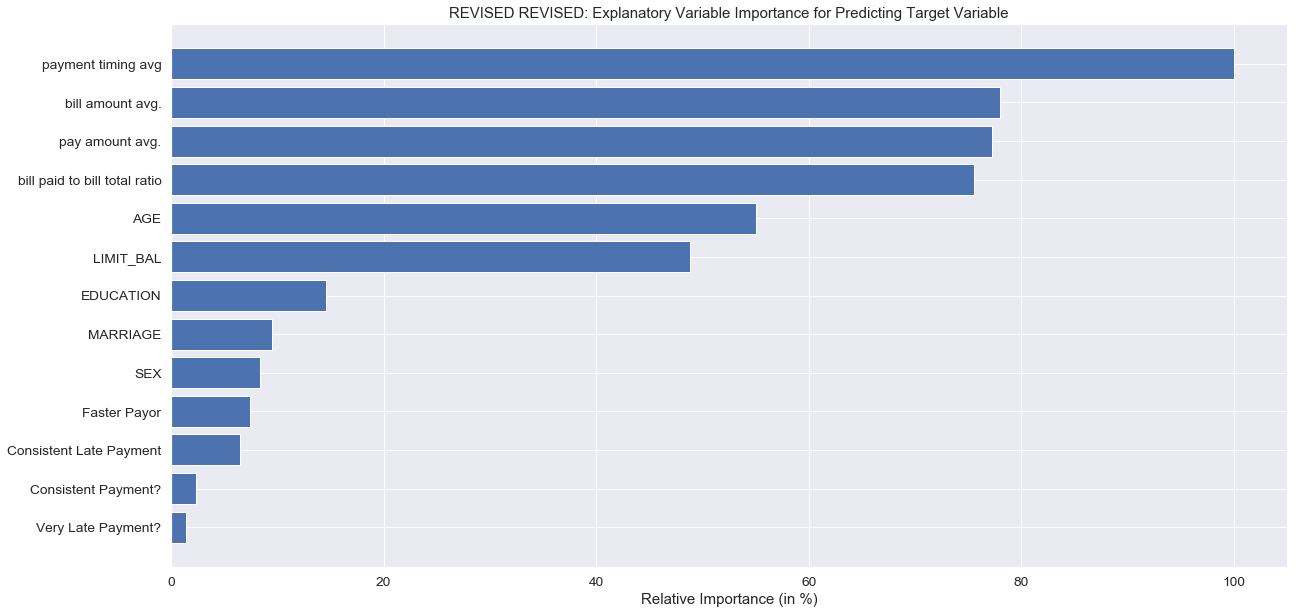

In [48]:
#---------------------------------------------------------

# re-running feature importance map

rfc.fit(X, Y)

feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(20,10))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance (in %)')
plt.title('REVISED REVISED: Explanatory Variable Importance for Predicting Target Variable')
plt.show()

It looks like exactly half of the newly created features are helpful in explaining the variance of the target variable, and half are not. Interestingly, the half that are not all deal with the timing of payment, which apparently is not helpful; _however_, the feature `payment timing avg` is the most important feature.

---
---
## Feature Selection - Correlation Heatmap

A heatmap visualizes the correlations not only between the features and the target variable, but also between the features themselves. This is important to note because co-linearity of features affects the ability to conclude that Feature A is significant in explaining the variance of the dataset (as opposed to Feature A _and_ its correlated Feature B).

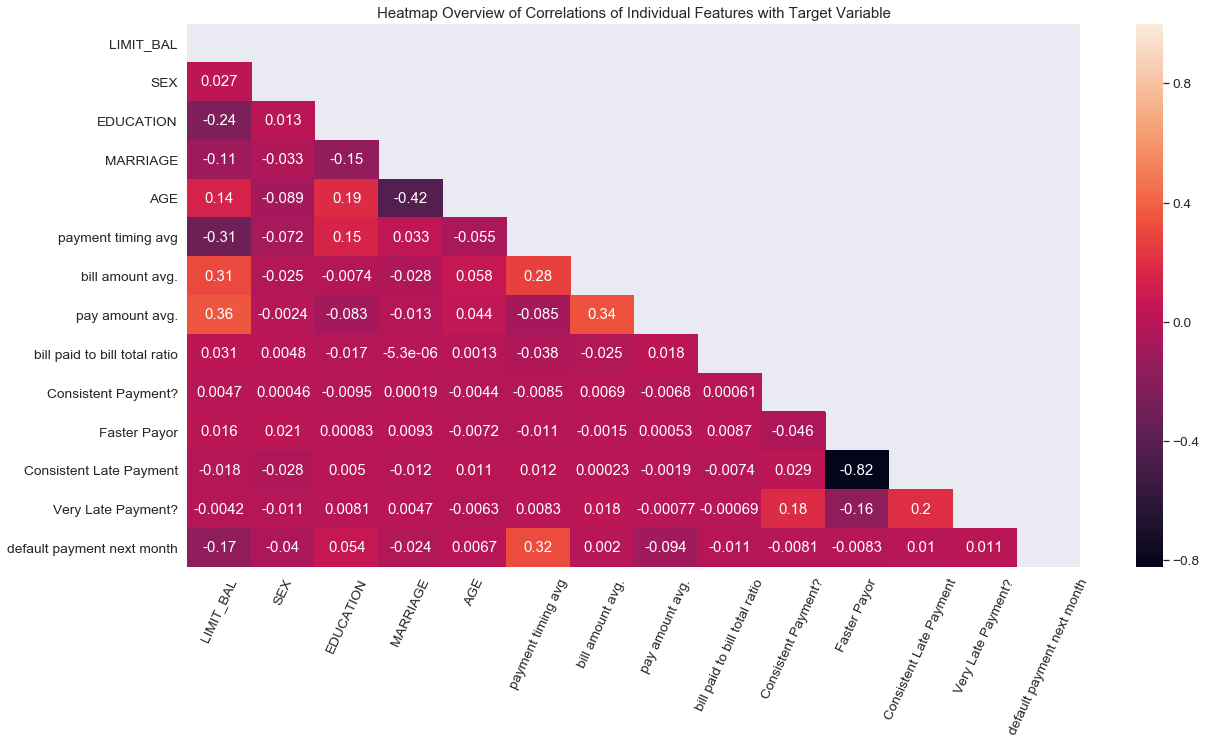

In [49]:
#NEW FEATURE ANALYSIS - correlation heatmap

feature_corr_list = X.copy()
feature_corr_list['default payment next month'] = Y

feature_corr = feature_corr_list.corr()

mask = np.zeros_like(feature_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,10))
ax = sns.heatmap(feature_corr, mask=mask, xticklabels=feature_corr_list.columns, 
                 yticklabels=feature_corr_list.columns, annot=True)

ax.set_xticklabels(labels=feature_corr_list.columns, rotation=65)

plt.title('Heatmap Overview of Correlations of Individual Features with Target Variable')

plt.show()

The heatmap gives us what the tree feature importance does not - raw correlation and not "relative" importance.  As you can see, really only `payment timing avg` yields at least _some_ explanatory power.

---
---
## Feature Selection - SHAP Value Modeling, Partial Dependence Plot, and Dependency Contribution Plot

These three feature selection methods are used all at once as they are all inter-connected methods.

1. __Partial Dependence Plotting__ 
    - If Permutation Importance modeling shows _which_ features are important, then PD plots show _how_ a given feature affects a prediction.
    - Much like our hold-one-out LASSO analysis, PD Plots alter a single feature in the dataset and see if this alteration changes the predictions.
    <br><br>
2. __"SHaply Additive exPlanation" ("SHAP") Value Analysis__
    - If Permutation modeling shows _which_ features are important, and PD plots show _how_ a feature is important, SHAP values are a measurement of _the extent_ that the feature impacts a prediction.
        - _How does it measure that?_: SHAP values calculate the importance of a feature by comparing what a model predicts with and without the feature. However, since the order in which a model sees features can affect its predictions, this is done in every possible order, so that the features are fairly compared. Instead of brute force running through all the order permutations, the SHAP library has optimizations that take advantage of decision tree analyses to stop an iteration if it is not helpful.
    - The sum of all SHAP values across the feature space is "the total predicted change from baseline."
        - "Baseline" means the average model prediction output based on the training data. The sum of all SHAP values stated above is the difference between the model prediction output of a particular test datapoint to the baseline output.
<br><br>
3. __Dependence Contribution Plotting__
    - These plots take Permutation Importance, Partial Dependence Plotting, and SHAP value analysis and wrap it all into one comprehensive plot.
    - Here, an analyzed feature is the x-axis and the SHAP values is on the y-axis.

These feature selection (err, more accurately, "feature analysis") methods will be demonstrated below.

---

### A Quick Note on Class Imbalance

As shown in the initial pie graph, over 3/4's of the dataset is said to "not default". A class imbalance will negatively affect how a model learns. Up until this point, we have not been doing formal modeling analysis, and so dealing with the class imbalance was not a concern.

While there are pandas methods to shuffle and take a fraction of the DataFrame to achieve a greater class balance, an easier method is using sklearn's `test_train_split`. In that function is a parameter called `stratify`, which matches the splitted datasets to the designated stratified array. In short, we set the parameter to `stratify=Y`.

In [50]:
# splitting data 

# Although I make an excuse for not doing it
# I should've done it as soon as I created X and Y...

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, random_state=666666)

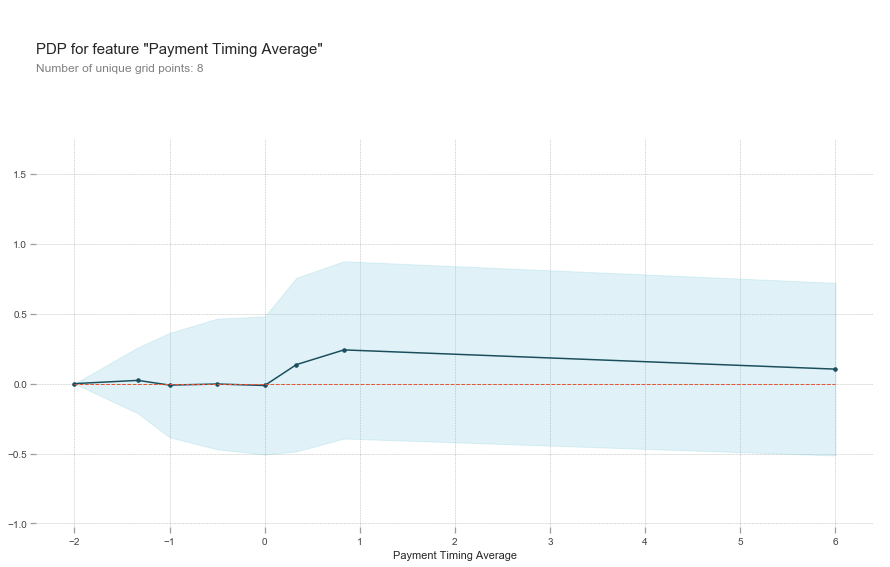

In [51]:
# PARTIAL DEPENDENCE PLOT 

from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(random_state=0).fit(X_train, Y_train)

from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, 
                            dataset=X_test, 
                            model_features=X_test.columns, 
                            feature='payment timing avg') # sample feature for PD Plot analysis 
                                                     

# plot it
pdp.pdp_plot(pdp_goals, 'Payment Timing Average')
plt.show()

# y-axis is change in prediction from what would be baseline prediction (i.e., 0)

__Analysis:__

Based on this graph, those who were, on average, about one month late in payment are the most likely to default. However, this should be noted that the vast majority of people fall in this range. This means that there are likely other features contributing to default. The gigantic confidence interval supports the lack of...confidence in the payment timing average correlation.

In [52]:
# SHAP VALUES

from sklearn.ensemble import RandomForestClassifier
my_model = RandomForestClassifier(n_estimators=350, random_state=0).fit(X_train, Y_train)


data_for_prediction = X_test.iloc[1000]  
# Could analyze 1, multiple rows, or the entire X_test (see "explainer" below)
# analyzing one row here for demonstration purposes

data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


my_model.predict_proba(data_for_prediction_array)

########################################################

import shap  # package used to calculate Shap values
from skimage import io
from skimage.color import rgb2gray

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
# The above variable creates two arrays - feature by feature probability of a negative outcome
# and feature by feature probability of a positive outcome

# may just use X_test for "data_for_prediction"

########################################################
# An easier way to understand the above SHAP value arrays is to visualize them
# Below is the code for that:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

# ----------------------------------------------------------------------------------------

# NOTE: If you are receiving an "ImportError", your version of scikit-image is outdated
# the bug that is causing the error is fixed in latest version:
# pip install --upgrade scikit-image or
# conda -c conda-forge scikit-image

# (I had to uninstall and reinstall...and had to do it through conda to work)
#


#-----------------------
# MAY HAVE TO RESTART KERNEL if you still have ImportErrors!!!!!!

In [54]:
print("The actual default(1)/no-default(0) for the actual set and the prediction is {} and {}, respectively.".format(Y[1000],
                                                                                                                  Y_test[1000])) 

The actual default(1)/no-default(0) for the actual set and the prediction is 0 and 0, respectively.


In [55]:
# SHAP SUMMARY PLOT

'''
The model will need to be adjusted for multi-datapoint analysis, such as SHAP summary plots and 
partial dependence plots. Otherwise, the model would take FOREVER.

You could use a more optimized tree model (such as "xgboost classifier"), 
but that is not done here.
'''

my_model = RandomForestClassifier(n_estimators=50, random_state=0).fit(X_train, Y_train)
explainer = shap.TreeExplainer(my_model)
shap_explained = explainer.shap_values(X_test[250:260]) #only using splice to speed things up

In [57]:
shap.summary_plot(shap_values=shap_explained[1], features=X_test[250:260], feature_names=X_test.columns)

__Analysis:__

This means for this particular point, the predicted probability that y==1 ("default") is 0.06. Because our current binarization is 50/50, this point is classified as zero (although we will adjust the binarization later - see below). There were multiple features pushing the predicted value down, with only `AGE` pushing it up (in my opinion, the colors are backwards).

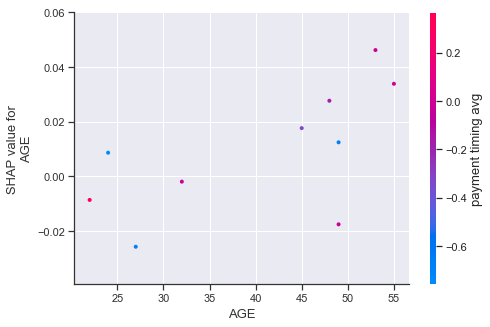

In [58]:
# DEPENDENCE CONTRIBUTION PLOT

shap.dependence_plot('AGE', shap_explained[1], X_test[250:260], interaction_index='payment timing avg')

# may need to restart kernel depending on overloading the plot or not

# Binarization and Analysis

The sklearn default for binary classifiers is a 50/50 split. In other words, if the model yields a 51% prediction that the datapoint falls into class 1 and not class 0, it will classify it as class 1.

Not surprisingly, the sensitivity of the model will want to be adjusted for different situations (more sensitive for fraudulent transactions, as not to miss any, and less sensitive for spam filters, as not flagging spam getting into the inbox is much better than a real e-mail getting flagged and put into the spambox).

---
---
## ROC Curves

To determine exactly what the cutoff point will be, we will use an __ROC Curve__. This curve visualizes the tradeoff between the __True Positive Rate__ (TPR) and the __False Positive Rate__ (FPR). Naturally, moving the binarization point from the default 50/50 to a lower threshold (e.g., adjusting to a 20% threshold probability for classification of "1") will create _more_ positive values.  

The ROC curve looks at the consequences of moving the binarization point in light of the particular dataset. Finding the point of the curve farthest away from the a TPR/FPR ratio of 1 will designate the binarization point for yielding the highest TPR/FPR ratio.  Of course, this is not _per se_ the best point to use, as you may opt to take a hit on accuracy if you want to play it more safe or less safe depending on the factual circumstances (such as instances of spam filters and analyzing fraudulent transactions - see above).

### But I'm getting a model accuracy of 90%! Why do I need to do this?

Be wary of this R-squared accuracy value! You need to measure your accuracy in light of the __null-accuracy__. In other words, if a model guessed the null - i.e., a predicted classification of "0" - every time, what would the accuracy be? If it's 88%, your model accuracy isn't doing much better. To take null-accuracy into account, you can either (1) manipulate your model accuracy to reflect a more accurate...accuracy, or (2) balance your data to make the null-accuracy 50% (or close to 50%).

For demonstration, I'll perform a Naive Bayes analysis with the entire dataset to see what my accuracy is.

In [70]:
# Naive Bayes model instantiation.

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

Y_pred = bnb.fit(X, Y).predict(X)

mislabeling = (Y != Y_pred).sum()

# Display our results.
print("Number of MISLABELED points out of a total {} points : {}".format(
    X.shape[0],
    mislabeling))
print('\nThat means a Naive Bayes accuracy of {}%.'.format((len(df) - mislabeling) / len(df) * 100))



# Measure via confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(Y, Y_pred)

# confusion matrix layout:
# [[(True Positive), (False Negative)],
#  [(False Positive), (True Negative)]]

Number of MISLABELED points out of a total 28915 points : 6149

That means a Naive Bayes accuracy of 78.7342209925644%.


array([[20635,  2069],
       [ 4080,  2131]], dtype=int64)

In [71]:
print('This accuracy is compared to the null accuracy of {}%'.format((len(df) - len(Y[Y == 1])) / len(df) * 100))

This accuracy is compared to the null accuracy of 78.51979941206986%


__Analysis:__

While 78% accuracy sounds like a good start to modeling...

the model pretty much gave us the null accuracy (if my calculations are correct, the model may have guessed a single positive point correctly (compare with original pie chart), so yay for that). This makes a binarization adjustment via analyzing the ROC curve all the more important.

In [78]:
from sklearn import metrics

# Determine probabilities

y_pred_prob = bnb.predict_proba(X_train)[:, 1] # using training data for better fitting!!!
y_pred_prob = y_pred_prob.reshape(-1,1)        # gotta reshape for it to work
# ^^^This means to predict probabilities of outcome from "class 1" for all rows

#good idea to graph out the probability distribution to get an idea of how to adjust
plt.hist(y_pred_prob, bins=40)
plt.title('Histogram Distribution of Probability of Expectation of Default among Entire Dataset')
plt.ylabel('Count')
plt.xlabel('Percent Probability of Default')
plt.show()

# How to determine this delineating point? How sensitive to make?
# Answer: ROC Curve. 
# ROC Curve tells you what sensitivity/specificity tradeoff you will be able to get

fpr, tpr, thresholds = metrics.roc_curve(Y_train, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim(0,1) # from 0% to 100%
plt.ylim(0,1)
plt.title('ROC curve for Naive Bayes Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
plt.grid(True)



__Analysis:__ Again, we want to find the point on the curve _farthest away_ from an imaginary line diagonally crossing through the graph. The sharp change in slope appears to best achieve this. Let's find a binarization threshold that gives us a TPR of ~56% and an FPR of (100% - ~16%).

In [79]:
# also for numerical points along this ROC curve for specific sensitivity, specificity:
def evaluate_threshold(threshold_percent):
    print('Sensitivity:', tpr[thresholds > threshold_percent][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold_percent][-1])

In [97]:
evaluate_threshold(0.195) # after a couple run-throughs, this is the best threshold that got to the desired TPR and FPR

Sensitivity: 0.5525976814083298
Specificity: 0.8442565186751233


In [98]:
# adjusting y_pred for this new threshold

from sklearn.preprocessing import binarize
y_pred = binarize(y_pred_prob, 0.195)

# Modeling

We finally got to this point. Our data is cleaned, visualized, and most importantly, balanced. Our feature space is constructed. Our prediction threshold is set. Now, which model that best explains the variance in the data (i.e., the _R-squared_ accuracies) will have to be tested against the other classification models.

We will use __six__ classification models:

1. Logistic Regression with LASSO (L1) regularization penalty
2. Logistic Regression with Ridge (L2) regularization penalty
3. Random Forest model (again, but with split data and different prediction threshold)
4. K-Nearest Neighbors classifier
5. SVM Classifier
6. ADAboost ensemble model

In [113]:
# MODEL 1. LASSO REGRESSION

from sklearn.linear_model import LogisticRegression

# checking differents regularization strengths to see if it makes a difference
# I could've done a loop...but then I didn't

# using class_weights='balanced' to ensure balanced data
# C is the inverse of the strength of the penalty parameter 'lambda' (smaller C --> stronger regularization)

logistregr0 = LogisticRegression(penalty='l1', C=0.05, class_weight='balanced', max_iter=500)
logistregr1 = LogisticRegression(penalty='l1', C=0.25, class_weight='balanced', max_iter=500)
logistregr2 = LogisticRegression(penalty='l1', C=0.65, class_weight='balanced', max_iter=500) 
logistregr3 = LogisticRegression(penalty='l1', C=1, class_weight='balanced', max_iter=500)
logistregr4 = LogisticRegression(penalty='l1', C=1.5, class_weight='balanced', max_iter=500)
logistregr5 = LogisticRegression(penalty='l1', C=2, class_weight='balanced', max_iter=500)
logistregr6 = LogisticRegression(penalty='l1', C=100, class_weight='balanced', max_iter=500)

#----------------------------------------------------------------

print('LASSO scores with C paramater = 0.05: ', cross_val_score(logistregr0, X, Y, cv=5))
print('\nLASSO scores with C paramater = 0.25: ', cross_val_score(logistregr1, X, Y, cv=5))
print('\nLASSO scores with C paramater = 0.65: ', cross_val_score(logistregr2, X, Y, cv=5))      
print('\nLASSO scores with C paramater = 1: ', cross_val_score(logistregr3, X, Y, cv=5))
print('\nLASSO scores with C paramater = 1.5: ', cross_val_score(logistregr4, X, Y, cv=5))
print('\nLASSO scores with C paramater = 2: ', cross_val_score(logistregr5, X, Y, cv=5))
print('\nLASSO scores with C paramater = 100: ', cross_val_score(logistregr6, X, Y, cv=5))


LASSO scores with C paramater = 0.05:  [0.64868603 0.64655023 0.63842296 0.71243299 0.67813905]

LASSO scores with C paramater = 0.25:  [0.65024205 0.64430227 0.63254366 0.71035795 0.67260464]

LASSO scores with C paramater = 0.65:  [0.65024205 0.64464811 0.63306242 0.70966626 0.67260464]

LASSO scores with C paramater = 1:  [0.64989627 0.64464811 0.63306242 0.7091475  0.67243168]

LASSO scores with C paramater = 1.5:  [0.65024205 0.64499395 0.63271658 0.7091475  0.67260464]

LASSO scores with C paramater = 2:  [0.65024205 0.64499395 0.63323534 0.70880166 0.67208578]

LASSO scores with C paramater = 100:  [0.64989627 0.64533979 0.63340827 0.7082829  0.67243168]


__Analysis:__ Our model is mildly better than the null accuracy (which, with balanced classes, is 50%...frustrating!). It appears that the L1 penalty does something, but not enough.

Moreover, the large jumps in accuracy betwee 63% and 71% suggest some overfitting. Just noting it here.

---

In [114]:
# MODEL 2: RIDGE REGRESSION

# This model's penalty shrinks irrelevant features - may be good for out feature space????

logistregr0 = LogisticRegression(penalty='l2', C=0.05, class_weight='balanced', max_iter=500)
logistregr1 = LogisticRegression(penalty='l2', C=0.25, class_weight='balanced', max_iter=500)
logistregr2 = LogisticRegression(penalty='l2', C=0.65, class_weight='balanced', max_iter=500) 
logistregr3 = LogisticRegression(penalty='l2', C=1, class_weight='balanced', max_iter=500)
logistregr4 = LogisticRegression(penalty='l2', C=1.5, class_weight='balanced', max_iter=500)
logistregr5 = LogisticRegression(penalty='l2', C=2, class_weight='balanced', max_iter=500)
logistregr6 = LogisticRegression(penalty='l2', C=100, class_weight='balanced', max_iter=500)

#----------------------------------------------------------------

print('Ridge scores with C paramater = 0.05: ', cross_val_score(logistregr0, X, Y, cv=5))
print('\nRidge scores with C paramater = 0.25: ', cross_val_score(logistregr1, X, Y, cv=5))
print('\nRidge scores with C paramater = 0.65: ', cross_val_score(logistregr2, X, Y, cv=5))      
print('\nRidge scores with C paramater = 1: ', cross_val_score(logistregr3, X, Y, cv=5))
print('\nRidge scores with C paramater = 1.5: ', cross_val_score(logistregr4, X, Y, cv=5))
print('\nRidge scores with C paramater = 2: ', cross_val_score(logistregr5, X, Y, cv=5))
print('\nRidge scores with C paramater = 100: ', cross_val_score(logistregr6, X, Y, cv=5))

Ridge scores with C paramater = 0.05:  [0.53907331 0.54054989 0.52481411 0.59277192 0.57298513]

Ridge scores with C paramater = 0.25:  [0.53907331 0.54054989 0.52481411 0.59277192 0.57298513]

Ridge scores with C paramater = 0.65:  [0.53907331 0.54054989 0.52481411 0.59277192 0.57298513]

Ridge scores with C paramater = 1:  [0.53907331 0.54054989 0.52481411 0.59277192 0.57298513]

Ridge scores with C paramater = 1.5:  [0.53907331 0.54054989 0.52481411 0.59277192 0.57298513]

Ridge scores with C paramater = 2:  [0.53907331 0.54054989 0.52481411 0.59277192 0.57298513]

Ridge scores with C paramater = 100:  [0.53907331 0.54054989 0.52481411 0.59277192 0.57298513]


__Analysis:__ Ridge regression gave us barely above the null accuracy. At least the L1 regularization did _something_. This shows that there is not one feature that is highly correlated with the target variable and therefore have all other features shrunk (but we knew that already, so I guess we shouldn't be surprised by these results).

---

In [115]:
# MODEL 3: RANDOM FOREST CLASSIFIER

# 'gini' = measurement of impurity (negative calculation)
# 'entropy' = measurement of amount of information gained for convergence (positive calculation)

#'balanced' = weights applied to balance classes (as used in the regressions above)
#'balanced_subsample' = weights are computed based on the input of data for each tree grown

rfc1 = ensemble.RandomForestClassifier(n_estimators=300, criterion='gini', class_weight='balanced')
rfc2 = ensemble.RandomForestClassifier(n_estimators=300, criterion='gini', class_weight='balanced_subsample')
rfc3 = ensemble.RandomForestClassifier(n_estimators=300, criterion='entropy', class_weight='balanced')
rfc4 = ensemble.RandomForestClassifier(n_estimators=300, criterion='entropy', class_weight='balanced_subsample')

#--------------------------------------

# cv=3 because computationally heavy, and I ain't got all day, kid.
print('\nRandom forest scores with {} criterion and {} class weight balancing: \n{}'.format('gini', 
                                                                                        'normal', 
                                                                                        cross_val_score(rfc1, X, Y, cv=3)))

print('\nRandom forest scores with {} criterion and {} class weight balancing: \n{}'.format('gini', 
                                                                                        'subsampling', 
                                                                                        cross_val_score(rfc2, X, Y, cv=3)))

print('\nRandom forest scores with {} criterion and {} class weight balancing: \n{}'.format('entropy', 
                                                                                        'normal', 
                                                                                        cross_val_score(rfc3, X, Y, cv=3)))

print('\nRandom forest scores with {} criterion and {} class weight balancing: \n{}'.format('entropy', 
                                                                                        'subsampling', 
                                                                                        cross_val_score(rfc4, X, Y, cv=3)))



Random forest scores with gini criterion and normal class weight balancing: 
[0.80080921 0.80670264 0.81292799]

Random forest scores with gini criterion and subsampling class weight balancing: 
[0.80371408 0.80732517 0.81489936]

Random forest scores with entropy criterion and normal class weight balancing: 
[0.80298786 0.80670264 0.81583316]

Random forest scores with entropy criterion and subsampling class weight balancing: 
[0.8021579  0.80877775 0.81489936]


__Analysis:__ Significantly better than the regression methods used above. This is likely because regressions require strong linearity and other assumptions. These assumptions are not required by non-linear modeling, such as random forests. This may be supported by strong accuracy scores in other non-linear modeling (i.e., KNN).

But first - another linear model (although [kernel tricks](https://en.wikipedia.org/wiki/Kernel_method) can get around the linearity!) - Support Vector Machines.

---

In [119]:
# MODEL 4: SVM Classifier

from sklearn.svm import SVC

# using default 'rbf' kernel
# using decision function shape (one-vs.-rest, as opposed to one-vs.-one)
# using default tolerance for stopping criterion (0.001) 

svm1 = SVC(C=0.01, class_weight='balanced', max_iter=2500)
svm2 = SVC(C=0.1, class_weight='balanced', max_iter=2500)
svm3 = SVC(C=0.5, class_weight='balanced', max_iter=2500)
svm4 = SVC(C=1, class_weight='balanced', max_iter=2500)
svm5 = SVC(C=2, class_weight='balanced', max_iter=2500)
svm6 = SVC(C=10, class_weight='balanced', max_iter=2500)

#----------------------------------------------------

print('SVM scores with C-parameter of 0.01: \n', cross_val_score(svm1, X, Y, cv=3))
print('\nSVM scores with C-parameter of 0.1: \n', cross_val_score(svm2, X, Y, cv=3))
print('\nSVM scores with C-parameter of 0.5: \n', cross_val_score(svm3, X, Y, cv=3))
print('\nSVM scores with C-parameter of 1: \n', cross_val_score(svm4, X, Y, cv=3))
print('\nSVM scores with C-parameter of 2: \n', cross_val_score(svm5, X, Y, cv=3))
print('\nSVM scores with C-parameter of 10: \n', cross_val_score(svm6, X, Y, cv=3))

# NOTE: SVMs **VERY** computationally intensive. This took a while to run. I got greedy.

SVM scores with C-parameter of 0.01: 
 [0.21485631 0.21477485 0.21477485]

SVM scores with C-parameter of 0.1: 
 [0.21485631 0.21477485 0.21477485]

SVM scores with C-parameter of 0.5: 
 [0.21485631 0.21477485 0.21477485]

SVM scores with C-parameter of 1: 
 [0.21651624 0.21726499 0.21840631]

SVM scores with C-parameter of 2: 
 [0.22108103 0.78636647 0.22577298]

SVM scores with C-parameter of 10: 
 [0.78597365 0.78688525 0.7860552 ]


__Analysis:__ Abyssmal scores with hard-line delineations, but as the C parameter increased (the classification being more lenient), it offered some results. 

In addition, even with a cap of max iterations of 2500, it still took a long time but (apparently) could not converge on an answer. SVMs require hard delineations for classification (with allowing for a little wiggle room depending on the strength of the C-parameter). This dataset is not conducive to working in a "hard delineation" environment. Echoing the non-linear random forest results, this dataset is more conducive to non-linear modeling, as we will (hopefully) see with KNN classification.

Another note on the length of time for SVMs to run: "__The fit time complexity is more than quadratic__ with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples." source: [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (emphasis added)

---

In [120]:
# MODEL 5: K-Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn2 = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn3 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn4 = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn5 = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn6 = KNeighborsClassifier(n_neighbors=5, weights='distance')

#-------------------------------------------------------------------

print('Score for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('1',
                                                                                         'uniformly',
                                                                                         cross_val_score(knn1, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('3',
                                                                                         'uniformly',
                                                                                         cross_val_score(knn2, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('5',
                                                                                         'uniformly',
                                                                                         cross_val_score(knn3, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('1',
                                                                                         'distance',
                                                                                         cross_val_score(knn4, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('3',
                                                                                         'distance',
                                                                                         cross_val_score(knn5, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('5',
                                                                                         'distance',
                                                                                         cross_val_score(knn6, X, Y, cv=5)))

Score for 1-Nearest Neighbors analysis with uniformly-weighted neighbors:  
[0.6922545  0.69064499 0.68407401 0.71156839 0.69647181]

Score for 3-Nearest Neighbors analysis with uniformly-weighted neighbors:  
[0.72890733 0.7300709  0.73024382 0.74701712 0.74749222]

Score for 5-Nearest Neighbors analysis with uniformly-weighted neighbors:  
[0.75242047 0.74822756 0.74978385 0.76430918 0.76098236]

Score for 1-Nearest Neighbors analysis with distance-weighted neighbors:  
[0.6922545  0.69064499 0.68407401 0.71156839 0.69647181]

Score for 3-Nearest Neighbors analysis with distance-weighted neighbors:  
[0.71473029 0.72056026 0.71468096 0.73923569 0.73279142]

Score for 5-Nearest Neighbors analysis with distance-weighted neighbors:  
[0.73236515 0.73543144 0.73231887 0.75514439 0.74437911]


__Analysis:__ Not as good as random forest, and about as good as SVM but took 1/5th the time to run. The difference between weighting the neighbors versus not does not appear to be significant.

However, it appears more neighbors helped (though I am sure there is a diminishing return with number of neighbors up to a point. Let's try K=7 and 10 just for kicks.

In [121]:
knn7 = KNeighborsClassifier(n_neighbors=7, weights='uniform')
knn8 = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn9 = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn10 = KNeighborsClassifier(n_neighbors=10, weights='distance')

#-------------------------------------------------------------------

print('Score for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('7',
                                                                                         'uniformly',
                                                                                         cross_val_score(knn7, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('7',
                                                                                         'distance',
                                                                                         cross_val_score(knn8, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('10',
                                                                                         'uniformly',
                                                                                         cross_val_score(knn9, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('10',
                                                                                         'distance',
                                                                                         cross_val_score(knn10, X, Y, cv=5)))


Score for 7-Nearest Neighbors analysis with uniformly-weighted neighbors:  
[0.7629668  0.75670067 0.75894864 0.77416566 0.76755448]

Score for 7-Nearest Neighbors analysis with distance-weighted neighbors:  
[0.74688797 0.74165658 0.74407747 0.76379042 0.75406434]

Score for 10-Nearest Neighbors analysis with uniformly-weighted neighbors:  
[0.7780083  0.77710531 0.77468442 0.7845409  0.78104462]

Score for 10-Nearest Neighbors analysis with distance-weighted neighbors:  
[0.75345781 0.75220474 0.7568736  0.7703614  0.76184711]


In [124]:
# still going up, although "distance" is hindering the score

knn11 = KNeighborsClassifier(n_neighbors=15, weights='uniform')
knn12 = KNeighborsClassifier(n_neighbors=25, weights='uniform')
knn13 = KNeighborsClassifier(n_neighbors=50, weights='uniform')
knn14 = KNeighborsClassifier(n_neighbors=100, weights='uniform')

#-------------------------------------------------------------------

print('Score for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('15',
                                                                                         'uniformly',
                                                                                         cross_val_score(knn11, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('25',
                                                                                         'uniformly',
                                                                                         cross_val_score(knn12, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('50',
                                                                                         'uniformly',
                                                                                         cross_val_score(knn13, X, Y, cv=5)))

print('\nScore for {}-Nearest Neighbors analysis with {}-weighted neighbors:  \n{}'.format('100',
                                                                                         'uniformly',
                                                                                         cross_val_score(knn14, X, Y, cv=5)))

Score for 15-Nearest Neighbors analysis with uniformly-weighted neighbors:  
[0.77282158 0.77433858 0.77572194 0.78333045 0.77914217]

Score for 25-Nearest Neighbors analysis with uniformly-weighted neighbors:  
[0.7780083  0.77900744 0.78108248 0.78557842 0.78502248]

Score for 50-Nearest Neighbors analysis with uniformly-weighted neighbors:  
[0.78129322 0.78488674 0.78488674 0.78661594 0.78554134]

Score for 100-Nearest Neighbors analysis with uniformly-weighted neighbors:  
[0.7835408  0.7854055  0.78315753 0.7862701  0.78450363]


__Analysis:__ diminishing returns (a.k.a. logarithmic gains) indeed with higher number of neighbors, although no discernable increase in runtime. Random forest still scores better (albeit takes much longer).

---

Final model to use is the __Adaptive boosting classifier__. This classifier "aims to convert a set of weak classifiers into a strong one."

In [125]:
# MODEL 6. AdaBooster

from sklearn.ensemble import AdaBoostClassifier

# default n_estimators=50, so I'm really going for broke here!

adaboost1 = AdaBoostClassifier(n_estimators=100, learning_rate=1)
adaboost2 = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
adaboost3 = AdaBoostClassifier(n_estimators=250, learning_rate=1)

#-------------------------------------------------------------------

print('AdaBoost Classifier score using {} estimators and learning rate of {}: \n{}'.format('100',
                                                                                           '1',
                                                                                           cross_val_score(adaboost1, X, Y, cv=3)))

print('\nAdaBoost Classifier score using {} estimators and learning rate of {}: \n{}'.format('100',
                                                                                           '0.1',
                                                                                           cross_val_score(adaboost1, X, Y, cv=3)))

print('\nAdaBoost Classifier score using {} estimators and learning rate of {}: \n{}'.format('250',
                                                                                           '1',
                                                                                           cross_val_score(adaboost3, X, Y, cv=3)))


AdaBoost Classifier score using 100 estimators and learning rate of 1: 
[0.80381782 0.81147541 0.8138618 ]

AdaBoost Classifier score using 100 estimators and learning rate of 0.1: 
[0.80381782 0.81147541 0.8138618 ]

AdaBoost Classifier score using 250 estimators and learning rate of 1: 
[0.80516651 0.81178668 0.81541814]


In [126]:
# more estimators = higher percentage?
adaboost4 = AdaBoostClassifier(n_estimators=500, learning_rate=1)

print('\nAdaBoost Classifier score using {} estimators and learning rate of {}: \n{}'.format('500',
                                                                                           '1',
                                                                                           cross_val_score(adaboost4, X, Y, cv=3)))



AdaBoost Classifier score using 500 estimators and learning rate of 1: 
[0.80713767 0.81074912 0.8157294 ]


__Analysis:__ Comparable scoring to the Random Forest classifier but significantly faster.  The boosting ability on the conversion of the classes is a real winner here. In fact, it is pretty known in the industry that [tree boosting models are almost always the best predictive classifier models.](https://brage.bibsys.no/xmlui/handle/11250/2433761). This dataset, which had values all over the place, is well-suited for non-linear classifiers such as the AdaBoost, Random Forest, and  KNN.

---
---

# FINAL ANALYSIS

Let's look at the final R-squared scores for each of the models.

These bars represent the average of the highest cross-validation scoreset, with the confidence interval also coming from that particular cross-validation scoreset.

In [142]:
cross_val_lists = [np.array([0.64989627, 0.64533979, 0.63340827, 0.7082829, 0.67243168]), # highest LASSO cross-val scoreset
                   np.array([0.53907331, 0.54054989, 0.52481411, 0.59277192, 0.57298513]),# Ridge
                   np.array([0.80371408, 0.80732517, 0.81489936]),                        # Random Forest
                   np.array([0.78597365, 0.78688525, 0.7860552]),                         # SVM
                   np.array([0.78129322, 0.78488674, 0.78488674, 0.78661594, 0.78554134]),# K-Nearest Neighbors
                   np.array([0.80713767, 0.81074912, 0.8157294])]                         # AdaBoost
                  
cross_val_mean = [np.mean(arry) for arry in cross_val_lists]
cross_val_std = [np.std(arry) for arry in cross_val_lists]

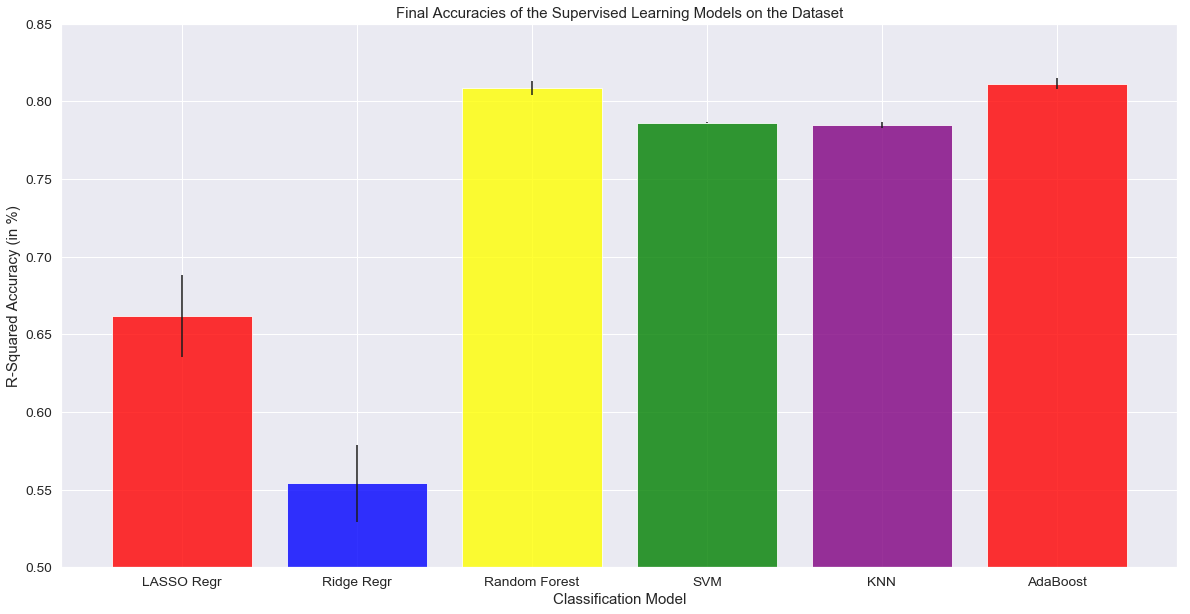

In [150]:
model_names = ['LASSO Regr', 'Ridge Regr', 'Random Forest', 'SVM', 'KNN', 'AdaBoost']
colors = ['red', 'blue', 'yellow', 'green', 'purple']

plt.figure(figsize=(20,10))

plt.bar(x=model_names, height=cross_val_mean, yerr=cross_val_std, color=colors, alpha=0.8) # need alpha --> hurts me eyes!
plt.title('Final Accuracies of the Supervised Learning Models on the Dataset')
plt.xlabel('Classification Model')
plt.ylim(0.5, 0.85)
plt.ylabel('R-Squared Accuracy (in %)')

plt.show()

# CONCLUSION

__Research Question to Investigate:__  Which financial factors are most important in determining whether a person will default on his or her credit card, and to what extent do these factors play a role in this determination?

---

__Answer to Research Question:__ According to feature importances, the timing of payments, on average, most influence a person's default-ability. Average monthly bill amounts and average monthly bill payments also play a role, albeit to a lesser extent. It appears that demographic factors do not play a significant role.

Accordingly, it is important to note that not one particular feature predicts the target variable; the dataset will have to be taken as a whole. This is why non-linear models such as Random Forest and AdaBoost fared the best in predicting the dataset.

---

__Practical Uses of the Model:__ This dataset can prove to be a good example of how financial factors predict default-ability. Therefore, the analyses have practical value to them.

---

__Shortcomings of the Dataset:__ Despite significant feature engineering, there was no one feature that established a smoking gun correlation with the target variable. Additionally, this data is collected over a six-month period (April 2005 to September 2005). This short-period may make the dataset overall unreliable.